In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import os
import matplotlib.pylab as plt
import scipy

# loading time series data
'''
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv',error_bad_lines=False)  #( time_series_19-covid-Confirmed.csv)
df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
'''
#df = pd.read_csv(url, error_bad_lines=False)
date='4/13/20'
odir='ModelC_without_lockdown_Indian-States' + date.replace('/','_') + '/'
try:  
    os.mkdir(odir)  
except OSError as error:  
    print('Directory exists: ', odir)

df=pd.read_csv('../india/refined_df_confirmed.csv')
states=df['State/UT']
df=df.set_index(['State/UT'])
start_from=np.where(df.columns == '15/02/20')[0][0]
df=df[df.columns[start_from:]]

In [119]:
def calc_slopes(confirmed_mat,thr=3,guess=1,extra=False):
    #slopes=np.zeros(50)
    l=len(states)
    fit_params = np.zeros([l,6])
    n=0
    t=10
    for i in range(l):
        idx=np.where(confirmed_mat[i,:]>=thr)[0][:10]
        #print(idx)
        y = np.log(confirmed_mat[i,idx.T])
        if len(y)>0:
            x = np.arange(len(y))
            z, res, _, _, _ = np.polyfit(x, y, guess,full=True)
            
            fit_params[i,0]=z[0]
            fit_params[i,1]=z[1]
            fit_params[i,2]=idx[0]
            fit_params[i,3]= np.log(confirmed_mat[i,idx[0]])
            fit_params[i,4]=res  
            for j in range(1,n+1):
                fit_params[i,5] +=  (y[t]- y[t-j])/j
            fit_params[i,5] = fit_params[i,5]/n
    return fit_params

In [120]:
initial_fit=calc_slopes(df.values,thr=20)
df_pop=pd.read_csv('../india/population_india_census2011.csv')
#index=np.where(states=='Maharashtra')[0][0]
#vals=initial_fit[index,:]

/home/srashti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


In [121]:
df_pop.head()

,Sno,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


In [122]:
odir1 = date.replace('/','_') + '/'

In [123]:
# plot settings
from matplotlib import rc
#matplotlib.rc('text.latex', preamble='\\usepackage{txfonts}')


#rc('text', usetex=True)
#rc('font', family='serif')
#rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)
rc('axes', labelsize=16)  # 24
rc("axes", linewidth=0.5)  # 2)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
rc('legend', fontsize=10)  # 16
rc('xtick.major', pad=6)  # 8)
rc('ytick.major', pad=6)  # 8)
rc('xtick.minor', size=5)  # 8)
rc('ytick.minor', size=5)  # 8)

In [124]:
# get time v/s confirmed cases(10-500) and Ti data for a particular country

def get_data(state,l=None):
    #ydata= df[df["Country"]==country].values[0,1:]
    ydata=df.loc[state].values
    ydata = np.array(ydata, dtype=float)
    idx=np.where(ydata>=20)[0][0]
    idx2= np.where(ydata>1)[0][0]
    #ydata=ydata[idx:]
    
    #idx1= np.where(ydata>=1000)[0][0]
    #ydata=ydata[:idx1]
    
    if l!=None:
        ydata = ydata[:l]
    max_days=len(ydata)
    xdata= np.arange(max_days)
    return xdata,ydata, idx


In [125]:
# SEIIRR Model Parameter Estimation
def seirc_ivp(x,y,p,beta,Tr,Tl,N):
    S,E,I,R = y
    sigma = 1/Tl
    Sd = -beta * (I) * S/N
    Ed = beta * (I) * S/N - sigma * E
    Id =  sigma * E - I/Tr
    Rd = I/Tr
    return Sd, Ed, Id, Rd

def eval_model_seirc(params,xdata,ydata,population,t0,min_routine=True): # params: parameters to optimize over: p

    p,beta = params
    N = population
    max_days=len(ydata)
    #Ti=1
    sigma= 1./Tl
    gamma= 1./Tr
    
    index=np.where(states==state)[0][0]
    vals=initial_fit[index,:]
    lam, C0=vals[0],np.exp(vals[1])
    #lam=-(sigma+gamma) + np.sqrt((sigma-gamma)**2 + 4* beta*sigma)/2
    R0=C0/p#*np.exp(lam*t0)
    phi4= [-beta/gamma,lam*(lam+gamma)/(sigma*gamma),lam/gamma,1]
    S0= N + phi4[0]*R0
    E0=phi4[1]*R0
    I0=phi4[2]*R0

    #Ti=10
   # beta=(lam+sigma)*(lam+gammaD)*(lam+gammaR)/(sigma*(lam+gammaD-p*(gammaD-gammaR)))
    if min_routine == True:
        sol = integrate.solve_ivp(seirc_ivp, [t0, max_days+1], [S0, E0, I0,R0], args=(p,beta,Tr,Tl,N),t_eval=np.arange(t0,max_days),method='RK45')
        #optim_days = min(100, max_days)  # Days to optimise for
        #weights = 1 / np.arange(1, optim_days+1)[::-1]  
        msle_cases = mean_squared_log_error(ydata[t0:], (p*sol.y[3,:])) 
        return msle_cases
    else:
        max_days=100
        sol = integrate.solve_ivp(seirc_ivp, [t0, max_days], [S0, E0, I0,R0], args=(p,beta,Tr,Tl,N),t_eval=np.arange(t0,max_days),method='RK45')
        return sol
    
import itertools
marker = itertools.cycle(( '*', 'o', '*')) 
no_bounds=(1e-5,1)
def fit_country_seiirr(state, population,bounds=no_bounds,l=14):
    N = population
    l=None
    xdata,ydata,t0=get_data(state,l)
    #print(t0)
    res_const = minimize(eval_model_seirc,[0.1,0.5], bounds=bounds,args=(xdata,ydata, population,t0),method='L-BFGS-B') ## numbers are initial guess
    
    msle_cases=eval_model_seirc(res_const.x,xdata,ydata,population,t0)
    plt.figure(figsize=(10,7))
    p,beta=res_const.x
    sigma= 1./Tl
    gamma= 1./Tr
    index=np.where(states==state)[0][0]
    vals=initial_fit[index,:]
    
    lam, intercept=vals[0],vals[1]
    
    #beta=(lam+sigma)*(lam+gammaD)*(lam+gammaR)/(sigma*(lam+gammaD-p*(gammaD-gammaR)))

    #coeff=[1,(gammaD + gammaR + sigma), gammaD*gammaR + sigma*(gammaD+gammaR-beta), p*beta*sigma*(gammaD-gammaR) + sigma*gammaD*(gammaR-beta) ]
    #coeff=np.array(coeff)
    #lambdas=np.roots(coeff)
   # lambdas=lambdas[lambdas>0]
    lambdas = (-(sigma+gamma) + np.sqrt((sigma-gamma)**2 + 4* beta*sigma))/2
    R0 = beta*(Tr)
    R0obs = beta*p*Tr
    la = state + ": p = %.5f, "%p +r" $\beta$ =  %3.2f, " %beta + 'MSLE = %.3f \n '%msle_cases + '$R_0$ = %.2f, '%R0 + '$R_0^o$ = %.2f, '%R0obs + '$\lambda^{est}$= %.3f'%(lambdas) 
    #print(Ti)
    sol= eval_model_seirc(res_const.x,xdata,ydata,population,t0,min_routine=False)

    xdata,ydata,t0=get_data(state)
    ini_fit= np.exp(lam*(xdata-t0)+intercept)
    plt.plot(xdata,ydata,marker=next(marker),linestyle='',label=state,markersize=10)
    plt.plot(xdata,ini_fit,'--',label='initial_fit %.3f'%lam)
    
    plt.plot(sol.t,p*sol.y[3,:],label = la ,linewidth=2)
    plt.plot(sol.t,sol.y[3,:],label='R')
    plt.plot(sol.t,sol.y[2,:],label='I')
    plt.axhline(population,linestyle='dashed',label='population')
    prefix=''
    if l!=None :
        plt.axvline(l, linestyle='dashed', color='gray')
        prefix=str(l)+'_'
    

    plt.yscale('log')
    plt.xlabel('Days')
    plt.ylabel('Confirmed cases fit with $R_d$')
    plt.grid()
    plt.tight_layout()
    plt.legend(fontsize=14)
    #prefix='full_'
    print(state, ': Estimated \lambda =',lambdas)
    plt.savefig(odir+prefix+state+'.png')
    return sol


Maharashtra : Estimated \lambda = 0.15827095575396882
Madhya Pradesh : Estimated \lambda = 0.1814925560986282
Gujarat : Estimated \lambda = 0.15016437365060092
Kerala : Estimated \lambda = 0.33087191611085975
Delhi : Estimated \lambda = 0.2895549221754651


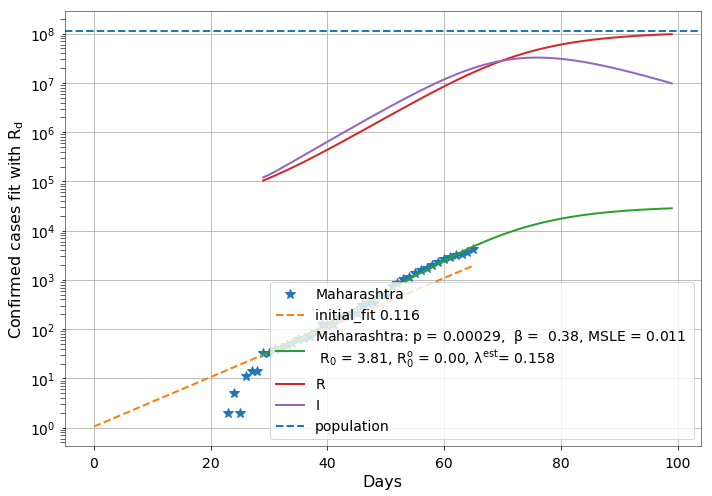

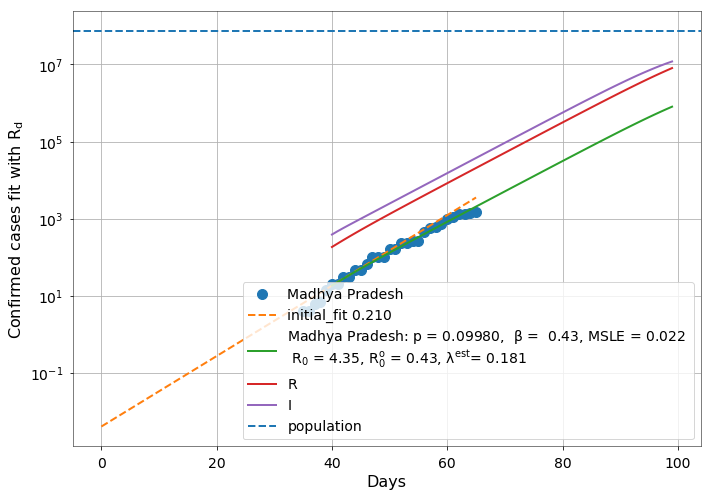

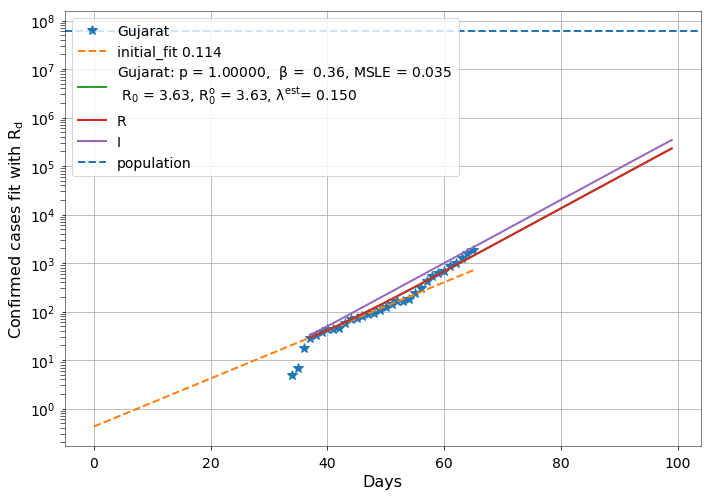

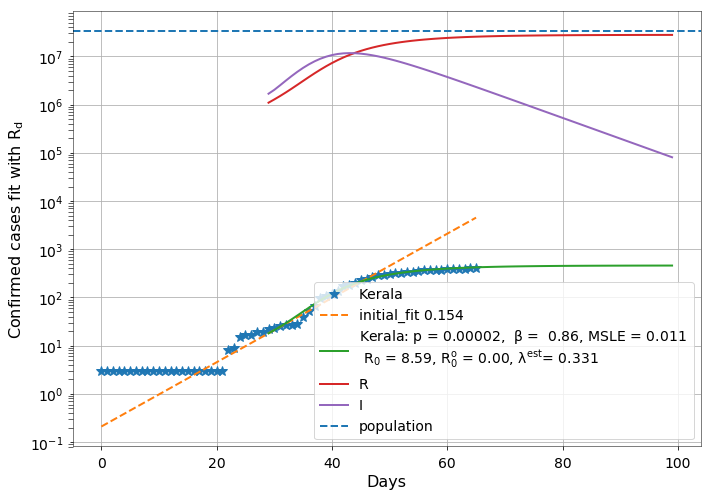

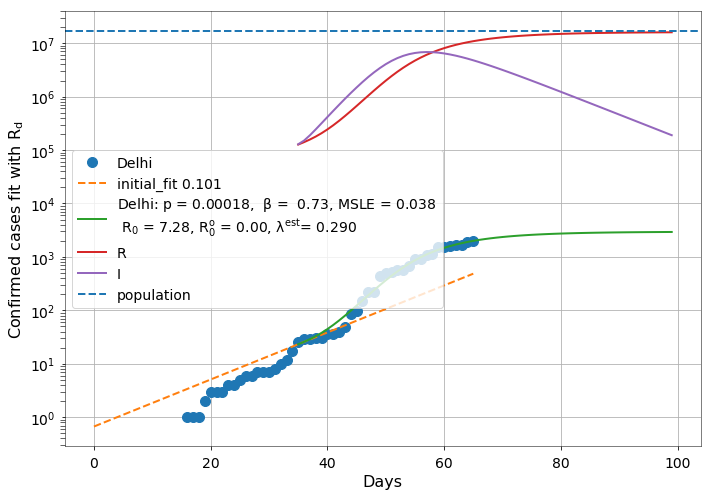

In [126]:
#bounds=[(0.00001,1e-4),(0.,2.5)]
## SEIIRR for Spain and Germany
bounds1=[(0.000001,1),(0.,2.5)] # ((pmin,pmax),(beta_min, beta_max))
#bounds1=((0.0001,.01),(0.6,.9),(1,10))

Tl = 3
Tr = 10
#Td = 7

state='Maharashtra'
population=df_pop[df_pop["State / Union Territory"]==state]["Population"].values[0]
_ = fit_country_seiirr(state,population,bounds=bounds1)
state='Madhya Pradesh'
population=df_pop[df_pop["State / Union Territory"]==state]["Population"].values[0]
_ = fit_country_seiirr(state,population,bounds=bounds1)
state='Gujarat'
population=df_pop[df_pop["State / Union Territory"]==state]["Population"].values[0]
_ = fit_country_seiirr(state,population,bounds=bounds1)
state='Kerala'
population=df_pop[df_pop["State / Union Territory"]==state]["Population"].values[0]
_ = fit_country_seiirr(state,population,bounds=bounds1)
state='Delhi'
population=df_pop[df_pop["State / Union Territory"]==state]["Population"].values[0]
_ = fit_country_seiirr(state,population,bounds=bounds1)